In [32]:
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, SpatialDropout1D, Input, TimeDistributed, Bidirectional
from keras.losses import Huber, MeanSquaredError
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
plt.style.use('fivethirtyeight')
import seaborn as sns

In [4]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

getting the data

In [5]:
    zinc_url = 'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_Zn_cash' 
    uClientzinc =uReq(zinc_url)
    page_html=uClientzinc.read()
    uClientzinc.close()
    page_soupzinc=soup(page_html, "html.parser")
    containerszinc=page_soupzinc.findAll("table")

    ZincList = []

    for tr in containerszinc:
        for tds in tr.find_all("td"):
            ZincList.append(tds)

    ZincList=[str(w).replace('<td>','') for w in ZincList]
    ZincList=[str(w).replace(',','') for w in ZincList]
    ZincList=[str(w).replace('</td>','') for w in ZincList]
    ZincList=[str(w).replace('<td class="last">','') for w in ZincList]

    zincdate = []
    zinccash = []
    zincthree = []
    zincstock = []

    for i in range(0,len(ZincList),4):
        zincdate.append(ZincList[i])
        zinccash.append(ZincList[i+1])
        zincthree.append(ZincList[i+2])
        zincstock.append(ZincList[i+3])

    zincd = {'Date': zincdate, "Close": zinccash, "LME_Zinc_3_month": zincthree, "LME_Zinc_stock": zincstock}
    zinc = pd.DataFrame(data=zincd)
    zinc = zinc.dropna()

In [6]:
zinc = zinc.drop(['LME_Zinc_3_month','LME_Zinc_stock'],axis=1)

In [7]:
zinc = zinc.dropna(axis=1)

In [8]:
zinc['Date'] = pd.to_datetime(zinc['Date'], format='%d. %B %Y')

In [9]:
for i in range(len(zinc.Date)):
    zinc.Date[i] = zinc.Date[i].strftime("%Y-%m-%d")

C:\Users\alpeker\AppData\Local\Temp\ipykernel_14324\4211785173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zinc.Date[i] = zinc.Date[i].strftime("%Y-%m-%d")


In [10]:
zinc.index=zinc['Date']

In [11]:
zinc = zinc.drop('Date',axis=1)

In [12]:
zinc = zinc[::-1]

fill the i-th value with the previous one if it is empty

In [13]:
for i in range(len(zinc.Close)):
    if zinc.Close[i] == '-':
        zinc.Close[i] = zinc.Close[i-1]

In [14]:
zinc.Close=pd.to_numeric(zinc.Close)

In [13]:
type(zinc.Close[0])

numpy.float64

Extract stock price data from Yahoo Finance

In [14]:
zinc

,Close
Date,
2008-01-02,2384.0
2008-01-03,2466.0
2008-01-04,2563.0
2008-01-07,2475.5
2008-01-08,2534.0
...,...
2022-06-01,3896.0
2022-06-06,3913.0
2022-06-07,3745.5


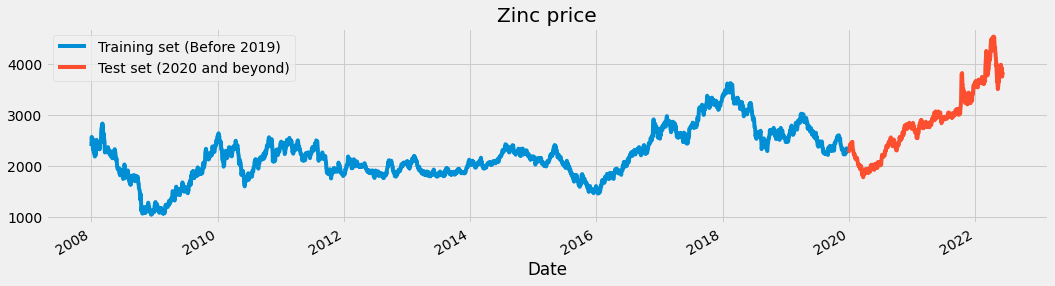

In [15]:
zinc["Close"][:'2019'].plot(figsize=(16,4),legend=True)
zinc["Close"]['2020':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019)','Test set (2020 and beyond)'])
plt.title('Zinc price')
plt.show()

I use log returns rather than the original data

In [17]:

zinc["log_returns"] = np.log(1 + zinc['Close'].pct_change())
zinc.dropna(inplace=True)
dataset = zinc.values
data_len = len(dataset)
n_feature = dataset.shape[1]
print(data_len)

3650


In [18]:
dataset

array([[ 2.46600000e+03,  3.38176555e-02],
       [ 2.56300000e+03,  3.85810426e-02],
       [ 2.47550000e+03, -3.47360516e-02],
       ...,
       [ 3.74550000e+03, -4.37492238e-02],
       [ 3.82200000e+03,  2.02187264e-02],
       [ 3.79200000e+03, -7.88026143e-03]])

MinMaxScaler scaled the data into range 0 to 1.

In [19]:
#Apply MinMaxScaler / Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [20]:
h = 360 #Test size
inp = 30 #Input size (days)

this part takes 30 days input and the very next day separately

In [23]:
train_data = scaled_data[0:data_len-h-inp,:] 
x_train = []
y_train = []
for i in range(inp, len(train_data)): 
  x_train.append(train_data[i-inp:i, :])
  y_train.append(train_data[i, :])


convert the data to numpy array

In [24]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [25]:
x_train.shape

(3230, 30, 2)

In [26]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_feature)) 

In [27]:
y_train.shape

(3230, 2)

Create the LSTM model

In [28]:
learning_rate = 0.01
epoch=10


input_model = Input(shape=(inp, n_feature))
lstm_model1 = Sequential(LSTM(50, return_sequences=False, activation='tanh')  )
output1 = lstm_model1(input_model)
dropout_layer = Dropout(0.2)
output2 = dropout_layer(output1)
dense_layer1 = Dense(inp)
output3 = dense_layer1(output2)
dense_layer2 = Dense(2)
output_final = dense_layer2(output3)
model = Model(input_model,output_final)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 2)]           0         
                                                                 
 sequential (Sequential)     (None, 50)                10600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 30)                1530      
                                                                 
 dense_1 (Dense)             (None, 2)                 62        
                                                                 
Total params: 12,192
Trainable params: 12,192
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss = [Huber(), MeanSquaredError()])
model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
101/101 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 2/10
101/101 [==============================] - 1s 11ms/step - loss: 0.0026
Epoch 3/10
101/101 [==============================] - 1s 11ms/step - loss: 0.0026
Epoch 4/10
101/101 [==============================] - 1s 11ms/step - loss: 0.0026
Epoch 5/10
101/101 [==============================] - 1s 11ms/step - loss: 0.0025
Epoch 6/10
101/101 [==============================] - 1s 11ms/step - loss: 0.0025
Epoch 7/10
101/101 [==============================] - 1s 11ms/step - loss: 0.0025
Epoch 8/10
101/101 [==============================] - 1s 11ms/step - loss: 0.0025
Epoch 9/10
101/101 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 10/10
101/101 [==============================] - 1s 13ms/step - loss: 0.0026


preparing the test data

In [31]:
test_data = scaled_data[data_len-(inp+h):data_len,:]
x_test = []
y_test = []
for i in range(inp, len(test_data)):
  x_test.append(test_data[i-inp:i, :])
  y_test.append(test_data[i, :])

In [32]:
x_test,y_test = np.array(x_test), np.array(y_test)

In [33]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

Error measurement

In [41]:
predictions = model.predict(x_test)
print('MSE: ', mean_squared_error(y_test[:,0], predictions[:,0],squared=True))
print('rmse: ',mean_squared_error(y_test[:,0], predictions[:,0],squared=False))
predictions = scaler.inverse_transform(predictions)
#predictions[:,0]

MSE:  0.0014161980377453641
rmse:  0.037632406749308026


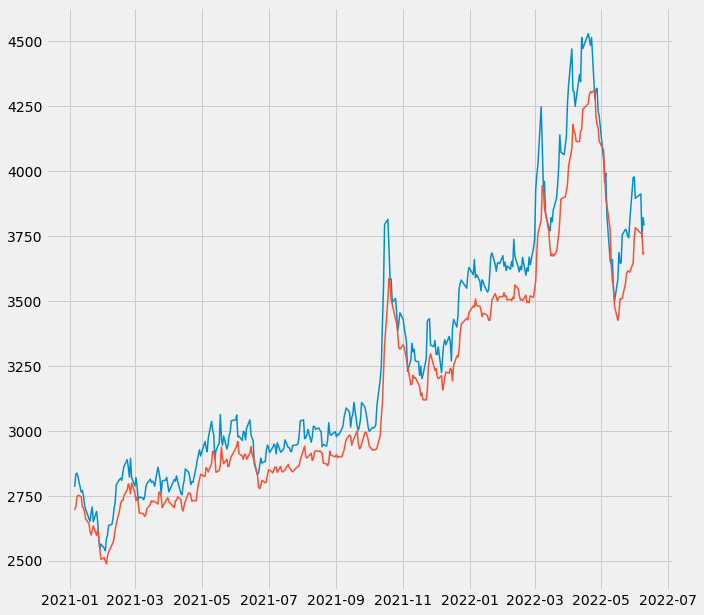

In [37]:
plt.figure(figsize=(10,10))
plt.plot(test[['Close','Predictions']],linewidth=1.5)

Predictions for the 30 days ahead

In [39]:
n_days = 30
data_pred = scaled_data[data_len-inp:data_len,:]
for i in range(0,n_days):
  x_pred = np.vstack(data_pred[i:i+inp, :])
  x_pred = np.array(x_pred)
  x_pred = np.reshape(x_pred, (1, x_pred.shape[0], n_feature))
  predict = model.predict(x_pred)
  data_pred = np.vstack((data_pred, predict))

In [42]:
predict_result = data_pred[len(data_pred)-n_days:len(data_pred),:]
predict_result = scaler.inverse_transform(predict_result)
print(predict_result[:,0]) #Hasil prediksi


[3673.01128387 3622.99508476 3569.12959862 3513.41192245 3457.27033615
 3401.55037308 3346.74787712 3293.14621735 3240.89903259 3190.08283043
 3140.72962761 3092.83921623 3046.39309311 3001.36464691 2957.71874237
 2915.4160862  2874.41572189 2834.67690086 2796.15929031 2758.82297325]


now i will create an arima model, i also developed another arima model which gives better results. I will upload it as a different notebook since its data preprocessing is a little bit different (i read it from my pc)

In [43]:
import statsmodels.api as sm

splitting tthe data into its components

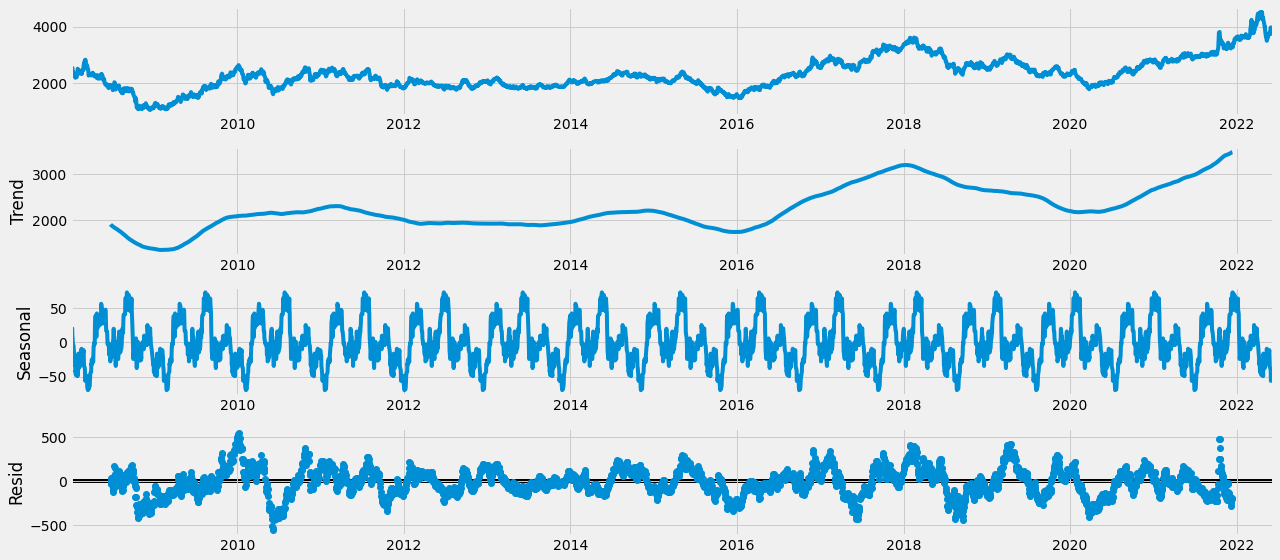

In [45]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(zinc, model = 'additive', period = 240)
fig = decomposition.plot()
plt.show()

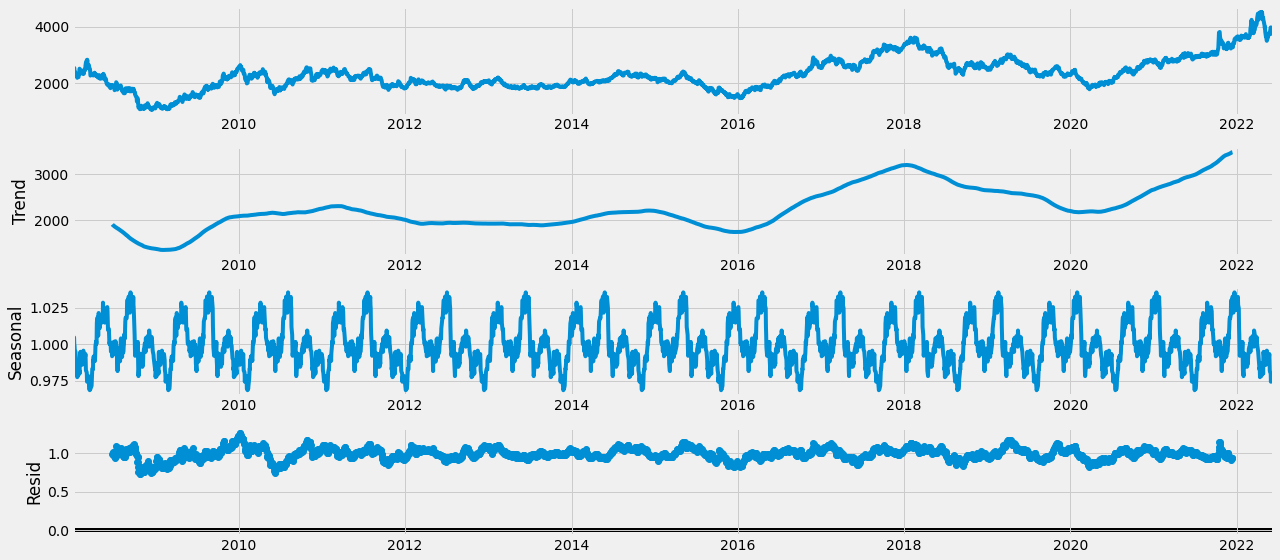

In [46]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(zinc, model = 'multiplicative', period = 240)
fig = decomposition.plot()
plt.show()

In [20]:

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools

c:\Users\alpeker\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


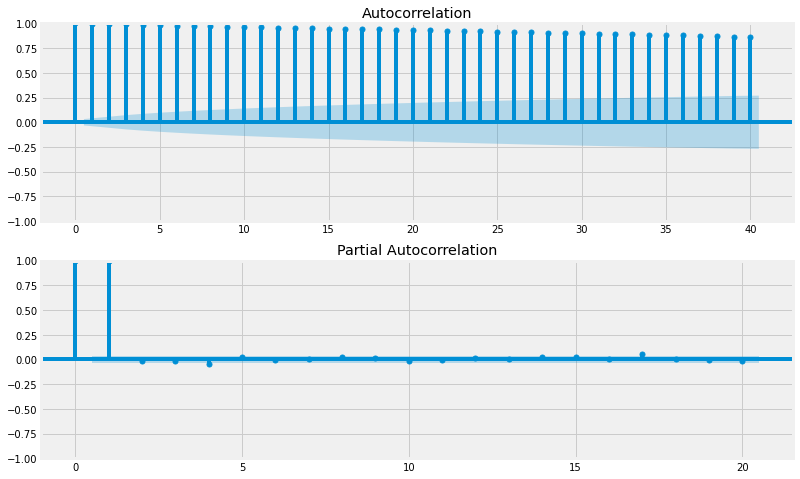

In [54]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(zinc.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(zinc, lags=20, ax=ax2)

checking prices yearly and monthly

In [29]:
zinc['year'] = [d.year for d in zinc.index]
zinc['month'] = [d.strftime('%b') for d in zinc.index]
years = zinc['year'].unique()

<AxesSubplot:xlabel='year', ylabel='Close'>

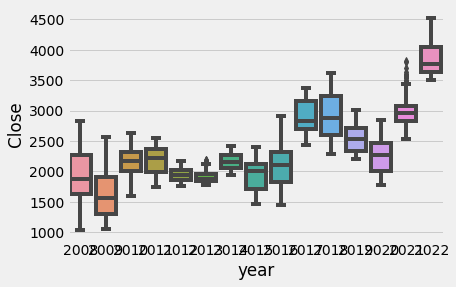

In [36]:
sns.boxplot(x='year', y='Close', data=zinc)

<AxesSubplot:xlabel='month', ylabel='Close'>

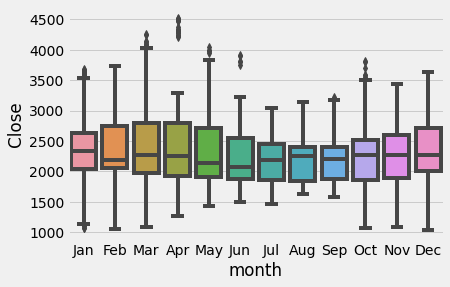

In [37]:
sns.boxplot(x='month', y='Close', data=zinc)

now we have to find p, d, q values

In [45]:
from pmdarima.arima import auto_arima

In [46]:
arima_model = auto_arima(zinc, start_p = 1, d=1, start_q = 1, 
                          max_p = 2, max_q = 2, max_d=2, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=2, max_D=2, max_Q=2,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=10) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=39623.792, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=39626.214, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=38697.452, Time=0.92 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=39626.961, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=38213.640, Time=2.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.45 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=38212.022, Time=1.88 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=38696.822, Time=0.85 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=11.30 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=4.99 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=38213.670, Time=2.84 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=38213.591, Time=3.01 sec
 ARIMA(0,1,0)(2,1,0)[12] intercep

fit the model

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(zinc,  
                order = (0, 1, 0),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

c:\Users\alpeker\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alpeker\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 3651
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood              -19103.011
Date:                            Fri, 10 Jun 2022   AIC                          38212.022
Time:                                    22:34:33   BIC                          38230.619
Sample:                                         0   HQIC                         38218.646
                                           - 3651                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6535      0.012    -53.342      0.000      -0.677      -0.629
ar.S.L24      -0.3632      0.012    -29.965      0.000      -0.387      -0.339
sigma2      2126.7427     32.497     65.444      0.000    2063.050    2190.436
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):              1182.20
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.02
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""